In [208]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
import numpy.ma as ma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
def NormMat(ConnMat):
    New_Mat = []
    for STR in ConnMat.index.values:
        STR_i_weights = ConnMat.loc[STR, :].values
        normed = [w/sum(STR_i_weights) for w in STR_i_weights]
        New_Mat.append(normed)
    return pd.DataFrame(data = New_Mat, index=ConnMat.index.values, columns = ConnMat.columns.values)

def DeDirection(ConnMat):
    New_Symmtric_Mat = ConnMat.copy(deep=True)
    for i, STR_i in enumerate(ConnMat.index.values):
        for j, STR_j in enumerate(ConnMat.columns.values):
            New_Symmtric_Mat.loc[STR_i, STR_j] = ConnMat.loc[STR_i, STR_j] + ConnMat.loc[STR_j, STR_i]
            New_Symmtric_Mat.loc[STR_j, STR_i] = ConnMat.loc[STR_i, STR_j] + ConnMat.loc[STR_j, STR_i]
    return New_Symmtric_Mat

In [1276]:
# Load Exp Bias
SparkMetaBias = pd.read_csv("dat/Jon_data/Spark_Final_ExpBias.csv")
SparkMetaBias.columns = ["STR", "EFFECT", "Rank", "NGene"]
SparkMetaBias = SparkMetaBias.set_index("STR")
STR2REG = STR2Region()

In [234]:
ConnFil="../dat/allen-mouse-conn/norm_density-max_ipsi_contra-pval_0.05-deg_min_1-by_weight.csv"
ConnMat = pd.read_csv(ConnFil, index_col=0) 
ConnMat_binary = ConnMat.mask(ConnMat>0, other = 1, inplace=False)

ConnMat_norm = NormMat(ConnMat)
ConnMat_binary_norm = NormMat(ConnMat_binary)

ConnMat_Symm = NormMat(DeDirection(ConnMat))
ConnMat_Symm_bin = NormMat(DeDirection(ConnMat_binary))

In [236]:
#for i, node in enumerate(ConnMat_Symm.index.values):
#    print(ConnMat_Symm.loc[node, :].values.sum())

# Step by Step

## Insolator Model

In [315]:
diffG = DiffusionGraph(SparkMetaBias, ConnMat_Symm)

In [316]:
states = diffG.Diffuse()

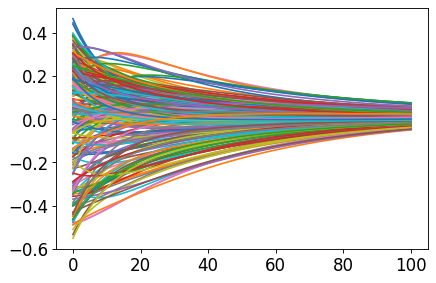

In [317]:
for i in range(states.shape[1]):
    plt.plot(states[:, i])

In [329]:
states_vec = diffG.Diffuse_vec(N=100)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
for i in range(states_vec.shape[1]):
    plt.plot(states_vec[:, i])

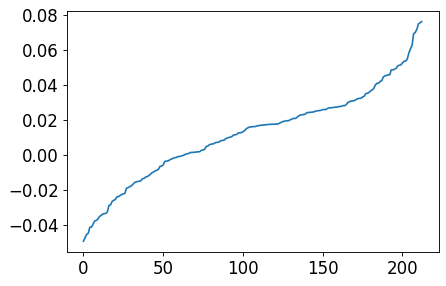

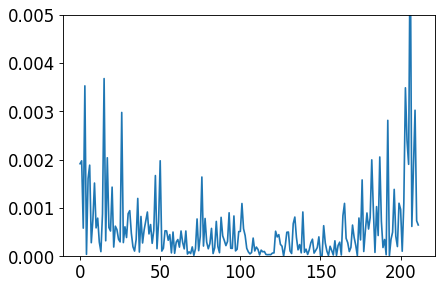

In [287]:
scores_rank = sorted(states[-1, :])
plt.plot(np.arange(213), scores_rank)
plt.show()
plt.plot(np.arange(212), [scores_rank[i] - scores_rank[i-1] for i in range(1, 213, 1)])
plt.ylim(0, 0.005)
plt.show()

In [288]:
indegrees = []; outdegrees = []
for node in diffG.NodeSeq:
    x,y = queryConnections(node, ConnMat, SparkMetaBias, STR2REG)
    indegrees.append(y)
    outdegrees.append(x)
#df = pd.DataFrame(data={"STR":diffG.NodeSeq, "REG":[STR2REG[x] for x in diffG.NodeSeq], 
#                        "Bias":diffG.Beta, "Score":states[-1,:]})
Biases = np.array([SparkMetaBias.loc[X, "EFFECT"] for X in diffG.NodeSeq])
df = pd.DataFrame(data={"STR":diffG.NodeSeq, "REG":[STR2REG[x] for x in diffG.NodeSeq],"Bias":Biases, "Score":states[-1,:], "InDegree":indegrees, "OutDegree":outdegrees})
df = df.sort_values("Score", ascending=False)
df["TotalD"] = df["InDegree"] + df["OutDegree"]
df.to_csv("Diffusion.Insolator.csv", index=False)

In [289]:
df.head(10)

,STR,REG,Bias,Score,InDegree,OutDegree,TotalD
100,Medial_septal_nucleus,Pallidum,-0.001277,0.076192,19,61,80
142,Parataenial_nucleus,Thalamus,0.187979,0.075545,19,43,62
102,Diagonal_band_nucleus,Pallidum,-0.109930,0.074812,29,50,79
46,Entorhinal_area_lateral_part,Hippocampal_formation,0.158973,0.071791,22,64,86
150,Nucleus_of_reuniens,Thalamus,0.265181,0.069948,28,56,84
121,Perirhinal_area,Isocortex,0.140374,0.069331,23,69,92
31,Central_linear_nucleus_raphe,Midbrain,-0.176038,0.062571,25,80,105
184,Subiculum_dorsal_part,Hippocampal_formation,0.329119,0.060669,11,50,61
74,Lateral_hypothalamic_area,Hypothalamus,-0.024410,0.058278,44,65,109
115,Piriform_amygdalar_area,Olfactory_areas,0.150233,0.054792,17,29,46


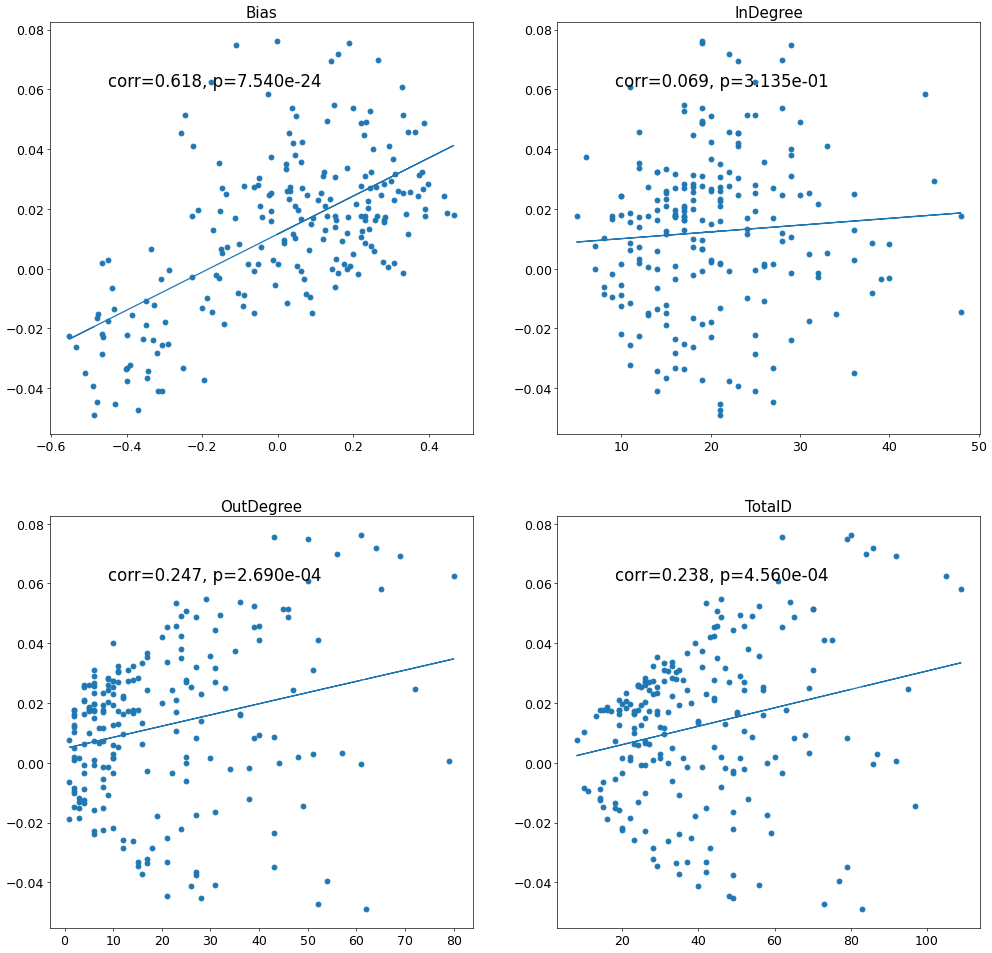

In [290]:
matplotlib.rc('font', **{'size': 15,})
fig, axs = plt.subplots(2, 2, figsize=(20, 20), dpi=60)
for ax, xx in zip(axs.flatten(), ["Bias", "InDegree", "OutDegree", "TotalD"]):
    x = df[xx].values
    y = df["Score"].values
    ax.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.set_title(xx)
    ax.plot(x, m*x + b)
    rho, p = pearsonr(x,y)
    ax.text(x=max(x) - (max(x)-min(x))*0.9, y=max(y)*0.8, s="corr=%.3f, p=%.3e"%(rho, p), fontsize=20)

## Source & Sink Model

(20001, 213)

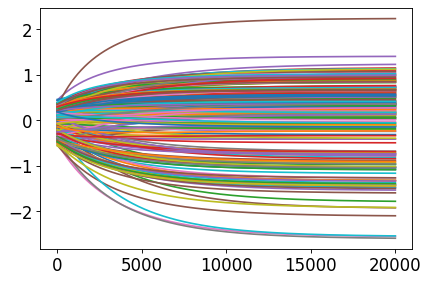

In [1365]:
diffG2_vec = DiffusionGraph(SparkMetaBias, ConnMat_norm)
states2_vec = diffG2_vec.Diffuse2_vec(N = 20000, alpha=1e-3, beta=1e-3)
for i in range(states2_vec.shape[1]):
    plt.plot(states2_vec[:, i])
states2_vec.shape

In [1370]:
def check_score(STR, diffG2_vec):
    idx = np.where(diffG2_vec.NodeSeq==STR)[0][0]
    print(diffG2_vec.States[-1, idx], diffG2_vec.InitBias[idx])

check_score("Ventral_tegmental_area", diffG2_vec)

-0.23733335488485652 -0.135874064155624


In [1371]:
indegrees = []; outdegrees = []; neighborbias = []
for node in diffG2_vec.NodeSeq:
    x,y,z = queryConnections(node, ConnMat, SparkMetaBias, STR2REG)
    indegrees.append(y)
    outdegrees.append(x)
    neighborbias.append(z)
Biases = np.array([SparkMetaBias.loc[X, "EFFECT"] for X in diffG2_vec.NodeSeq])
df = pd.DataFrame(data={"STR":diffG2_vec.NodeSeq, "REG":[STR2REG[x] for x in diffG.NodeSeq], 
                        "Score":states2_vec[-1,:], 
                        "Bias":Biases, "NeighborBias":neighborbias, "InDegree":indegrees, "OutDegree":outdegrees})
df = df.sort_values("Score", ascending=False)
df["TotalD"] = df["InDegree"] + df["OutDegree"]
df.to_csv("Diffusion.Souce_Sink.csv", index=False)

In [1361]:
E = np.zeros((213, 213))
for i, src_node in enumerate(diffG2_vec.Matrix.index.values):
    for j, tgt_node in enumerate(diffG2_vec.Matrix.columns.values):
        xx = diffG2_vec.Matrix.loc[src_node, tgt_node] * states2_vec[-1, i]
        if src_node == "Substantia_nigra_compact_part":
            print(states2_vec[-1, i])
        E[i,j] = xx

0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175
0.23362967954743175


In [1284]:
DF = pd.DataFrame(data=E, index=diffG2_vec.Matrix.index.values, columns=diffG2_vec.Matrix.columns.values)

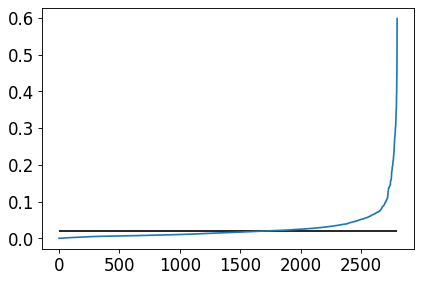

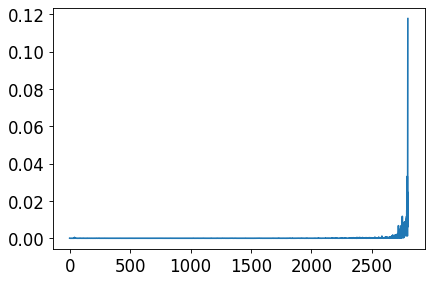

In [1309]:
edges_rank = sorted([x for x in DF.values.flatten() if x > 0])
plt.plot(np.arange(len(edges_rank)), edges_rank)
cut = 0.02
plt.hlines(y = cut, xmin = 0, xmax = len(edges_rank), colors="black")
plt.show()
plt.plot(np.arange(len(edges_rank)-1), [edges_rank[i] - edges_rank[i-1] for i in range(1, len(edges_rank), 1)])
plt.show()

In [1357]:
xx = DF.loc["Substantia_nigra_compact_part", :].sort_values(ascending=False)
print(sum(xx))
xx[xx>0]

0.23362967954743175


Caudoputamen                                0.047103
Superior_colliculus_motor_related           0.041965
Pedunculopontine_nucleus                    0.032286
Periaqueductal_gray                         0.031956
Dorsal_nucleus_raphe                        0.030093
Intermediodorsal_nucleus_of_the_thalamus    0.026849
Central_linear_nucleus_raphe                0.023377
Name: Substantia_nigra_compact_part, dtype: float64

In [1358]:
xx = DF.loc[:, "Substantia_nigra_compact_part"].sort_values(ascending=False)
print(sum(xx))
xx[xx>0]

0.5809944157693269


Caudoputamen                        0.319003
Fundus_of_striatum                  0.184987
Nucleus_accumbens                   0.101629
Globus_pallidus_external_segment    0.069112
Claustrum                           0.018420
Gustatory_areas                     0.015988
Lateral_hypothalamic_area           0.015888
Orbital_area_lateral_part           0.015014
Secondary_motor_area                0.012196
Primary_motor_area                  0.007019
Name: Substantia_nigra_compact_part, dtype: float64

In [1332]:
DF_nonD_mask = DF.mask(DF<0.03, other=0)

In [1333]:
g_test = LoadConnectome2(DF_nonD_mask)

In [1334]:
g_test_lg = g_test.clusters().giant()
xx = g_test_lg.vs.select(_degree_gt=2)
g_test_trim = g_test_lg.subgraph(xx)

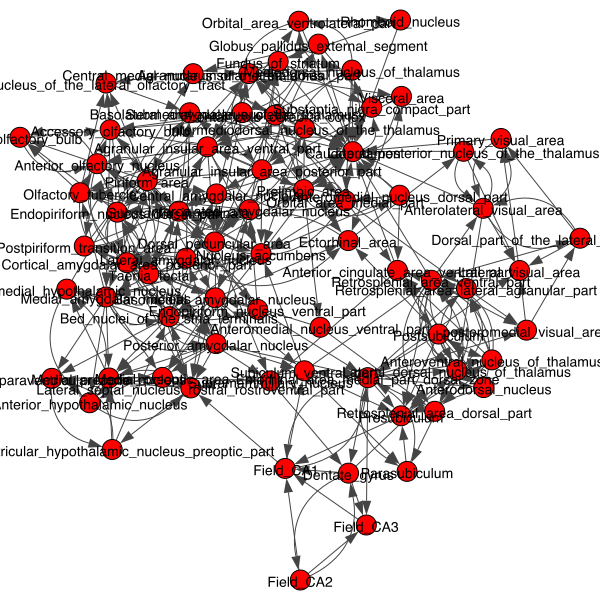

In [1335]:
ig.plot(g_test_trim)

In [1356]:
print(len(g_test_lg.vs["label"]))
RegionDistributionsList(g_test_lg.vs["label"])

72
Striatum 	 8 	 Nucleus_accumbens; Central_amygdalar_nucleus; Caudoputamen; Fundus_of_striatum; Intercalated_amygdalar_nucleus; Lateral_septal_nucleus_rostral_rostroventral_part; Medial_amygdalar_nucleus; Olfactory_tubercle
Pallidum 	 3 	 Bed_nuclei_of_the_stria_terminalis; Globus_pallidus_external_segment; Substantia_innominata
Thalamus 	 12 	 Anterodorsal_nucleus; Anteromedial_nucleus_dorsal_part; Anteromedial_nucleus_ventral_part; Anteroventral_nucleus_of_thalamus; Central_medial_nucleus_of_the_thalamus; Intermediodorsal_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus
Olfactory_areas 	 9 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Cortical_amygdalar_area_posterior_part; Dorsal_peduncular_area; Main_olfactory_bulb; Nucleus_of_the_lateral_olfactory_tract; Piriform_area; Postpiriform_tra

In [1215]:
str2reg = STR2Region()
for i in enumerate(g_test_lg.vs):
    label_ = g_test_lg.vs[i]["label"][0]
    g_test_lg.vs[i]["region"] = str2reg[label_]
    g_test_lg.vs[i]["Bias"] = SparkMetaBias.loc[label_, "EFFECT"]
    g_test_lg.vs[i]["Bias_Rank"] = SparkMetaBias.loc[label_, "Rank"]

In [1216]:
g_test_trim.write_gml("./circuits.test.gml")

In [385]:
indegrees = []; outdegrees = []; neighborbias = []
for node in diffG2.NodeSeq:
    x,y,z = queryConnections(node, ConnMat, SparkMetaBias, STR2REG)
    indegrees.append(y)
    outdegrees.append(x)
    neighborbias.append(z)
Biases = np.array([SparkMetaBias.loc[X, "EFFECT"] for X in diffG.NodeSeq])
df_bin = pd.DataFrame(data={"STR":diffG2.NodeSeq, "REG":[STR2REG[x] for x in diffG.NodeSeq], "Score":states2_bin[-1,:], 
                        "Bias":Biases, "NeighborBias":neighborbias, "InDegree":indegrees, "OutDegree":outdegrees})
df_bin = df_bin.sort_values("Score", ascending=False)
df_bin["TotalD"] = df_bin["InDegree"] + df_bin["OutDegree"]
df_bin.to_csv("Diffusion.Souce_Sink.bin.csv", index=False)

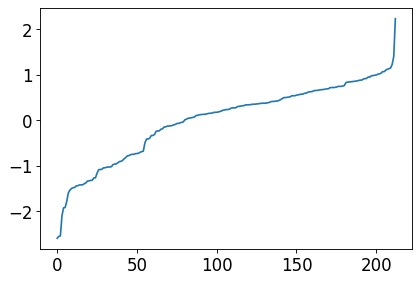

In [1353]:
scores_rank = sorted(states2_vec[-1, :])
plt.plot(np.arange(213), scores_rank)
plt.show()

In [1259]:
indegrees = []; outdegrees = []; neighborbias = []
for node in diffG2.NodeSeq:
    x,y,z = queryConnections(node, ConnMat, SparkMetaBias, STR2REG)
    indegrees.append(y)
    outdegrees.append(x)
    neighborbias.append(z)
Biases = np.array([SparkMetaBias.loc[X, "EFFECT"] for X in diffG.NodeSeq])
df = pd.DataFrame(data={"STR":diffG2.NodeSeq, "REG":[STR2REG[x] for x in diffG.NodeSeq], "Score":states2_vec[-1,:], 
                        "Bias":Biases, "NeighborBias":neighborbias, "InDegree":indegrees, "OutDegree":outdegrees})
df = df.sort_values("Score", ascending=False)
df["TotalD"] = df["InDegree"] + df["OutDegree"]
df.to_csv("Diffusion.Souce_Sink.csv", index=False)

In [1260]:
df.head(10)

,STR,REG,Score,Bias,NeighborBias,InDegree,OutDegree,TotalD
35,Caudoputamen,Striatum,2.259144,0.301286,6.931229,45,6,51
14,Anterior_olfactory_nucleus,Olfactory_areas,1.080557,0.351813,3.624339,18,6,24
3,Nucleus_accumbens,Striatum,1.068068,0.381976,2.864848,22,11,33
128,Piriform_area,Olfactory_areas,1.040124,0.229540,8.039937,18,31,49
95,Secondary_motor_area,Isocortex,1.034698,0.274129,7.051300,23,72,95
13,Accessory_olfactory_bulb,Olfactory_areas,1.034581,0.340150,3.046762,16,5,21
129,Prelimbic_area,Isocortex,1.017119,0.399311,6.310500,18,15,33
24,Field_CA1,Hippocampal_region,0.989659,0.448538,1.447486,11,5,16
46,Entorhinal_area_lateral_part,Hippocampal_formation,0.989468,0.158973,15.675329,22,64,86
48,Endopiriform_nucleus_dorsal_part,Cortical_subplate,0.931533,0.318983,3.703228,20,4,24


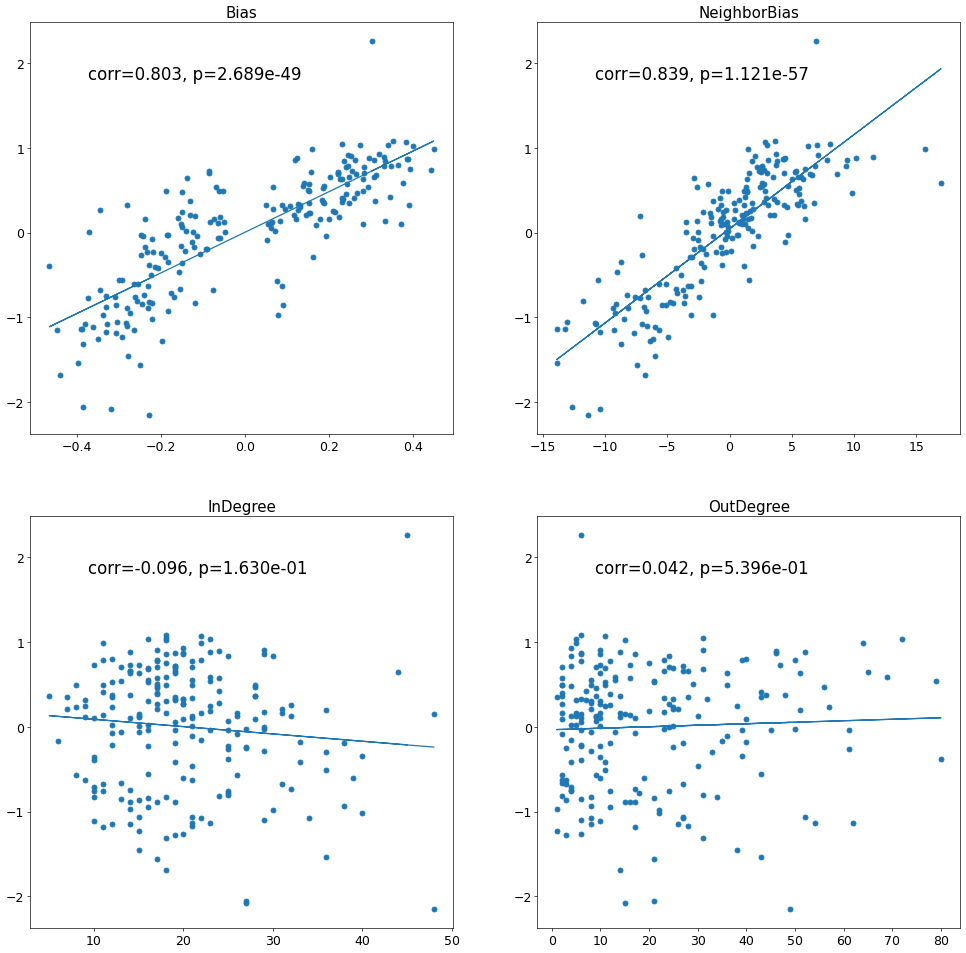

In [1261]:
matplotlib.rc('font', **{'size': 15,})
fig, axs = plt.subplots(2, 2, figsize=(20, 20), dpi=60)
for ax, xx in zip(axs.flatten(), ["Bias",  "NeighborBias", "InDegree", "OutDegree"]):
    x = df[xx].values
    y = df["Score"].values
    ax.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.set_title(xx)
    ax.plot(x, m*x + b)
    rho, p = pearsonr(x,y)
    ax.text(x=max(x) - (max(x)-min(x))*0.9, y=max(y)*0.8, s="corr=%.3f, p=%.3e"%(rho, p), fontsize=20)

In [382]:
diffG2_bin = DiffusionGraph(SparkMetaBias, ConnMat_Symm_bin)
states2_bin = diffG2_bin.Diffuse2()

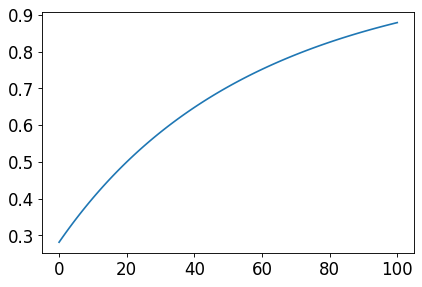

In [383]:
plt.plot(states2_bin[:, 1])

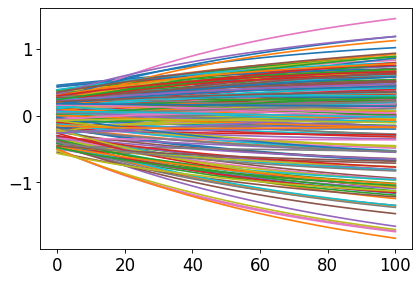

In [384]:
for i in range(states2_bin.shape[1]):
    plt.plot(states2_bin[:, i])

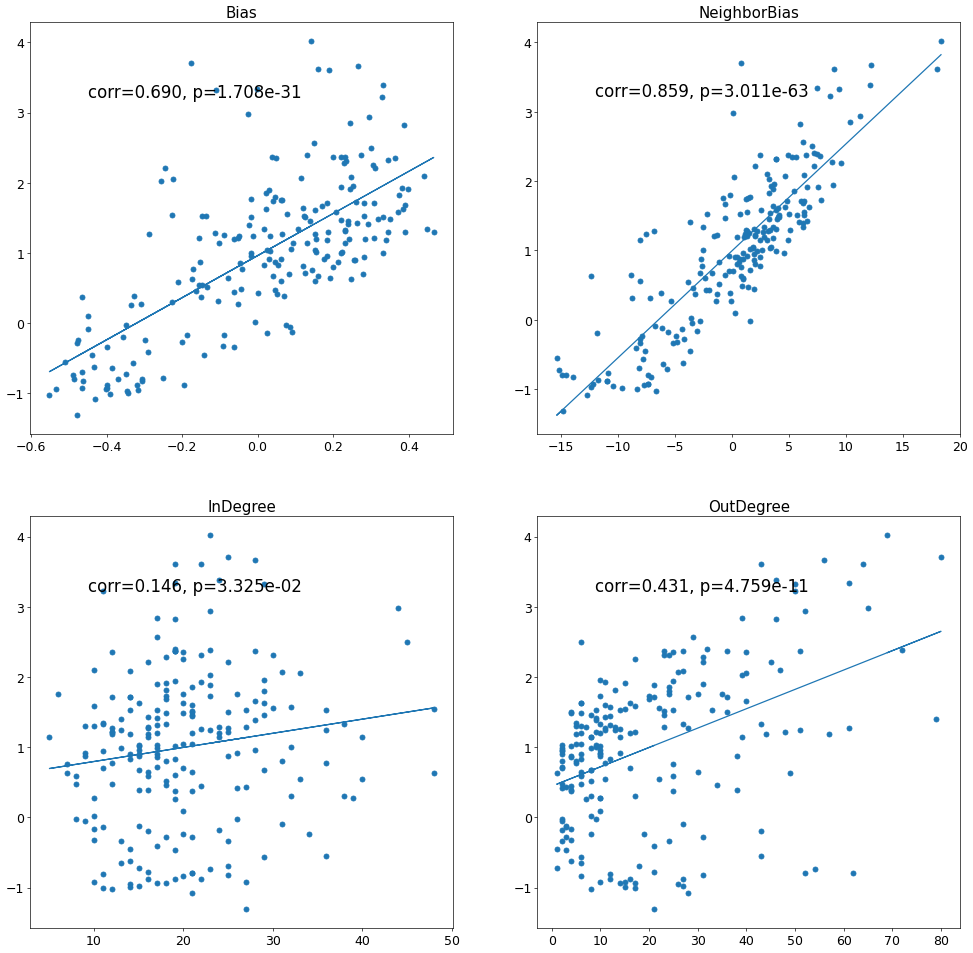

In [386]:
matplotlib.rc('font', **{'size': 15,})
fig, axs = plt.subplots(2, 2, figsize=(20, 20), dpi=60)
for ax, xx in zip(axs.flatten(), ["Bias",  "NeighborBias", "InDegree", "OutDegree"]):
    x = df[xx].values
    y = df["Score"].values
    ax.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.set_title(xx)
    ax.plot(x, m*x + b)
    rho, p = pearsonr(x,y)
    ax.text(x=max(x) - (max(x)-min(x))*0.9, y=max(y)*0.8, s="corr=%.3f, p=%.3e"%(rho, p), fontsize=20)

In [387]:
df.head(2)

,STR,REG,Score,Bias,NeighborBias,InDegree,OutDegree,TotalD
121,Perirhinal_area,Isocortex,4.021253,0.140374,18.332503,23,69,92
31,Central_linear_nucleus_raphe,Midbrain,3.707541,-0.176038,0.751465,25,80,105


In [372]:
df_bin.head(2)

,STR,REG,Score,Bias,NeighborBias,InDegree,OutDegree,TotalD
46,Entorhinal_area_lateral_part,Hippocampal_formation,4.147207,0.158973,17.983872,22,64,86
121,Perirhinal_area,Isocortex,3.757017,0.140374,18.332503,23,69,92


In [374]:
xx = df.join(df_bin, lsuffix="_w", rsuffix='_b')
xx

,STR_w,REG_w,Score_w,Bias_w,NeighborBias_w,InDegree_w,OutDegree_w,TotalD_w,STR_b,REG_b,Score_b,Bias_b,NeighborBias_b,InDegree_b,OutDegree_b,TotalD_b
121,Perirhinal_area,Isocortex,4.021253,0.140374,18.332503,23,69,92,Perirhinal_area,Isocortex,3.757017,0.140374,18.332503,23,69,92
31,Central_linear_nucleus_raphe,Midbrain,3.707541,-0.176038,0.751465,25,80,105,Central_linear_nucleus_raphe,Midbrain,2.789652,-0.176038,0.751465,25,80,105
150,Nucleus_of_reuniens,Thalamus,3.666923,0.265181,12.163084,28,56,84,Nucleus_of_reuniens,Thalamus,3.729450,0.265181,12.163084,28,56,84
46,Entorhinal_area_lateral_part,Hippocampal_formation,3.614810,0.158973,17.983872,22,64,86,Entorhinal_area_lateral_part,Hippocampal_formation,4.147207,0.158973,17.983872,22,64,86
142,Parataenial_nucleus,Thalamus,3.611708,0.187979,8.977783,19,43,62,Parataenial_nucleus,Thalamus,2.831560,0.187979,8.977783,19,43,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Spinal_vestibular_nucleus,Medulla,-0.991097,-0.342570,-9.617233,14,15,29,Spinal_vestibular_nucleus,Medulla,-0.761220,-0.342570,-9.617233,14,15,29
39,Dorsal_cochlear_nucleus,Medulla,-1.003015,-0.391136,-8.340021,11,17,28,Dorsal_cochlear_nucleus,Medulla,-0.786696,-0.391136,-8.340021,11,17,28
198,Facial_motor_nucleus,Medulla,-1.026560,-0.551476,-6.706312,12,8,20,Facial_motor_nucleus,Medulla,-0.866918,-0.551476,-6.706312,12,8,20
175,Spinal_nucleus_of_the_trigeminal_oral_part,Medulla,-1.080290,-0.430325,-12.690486,21,28,49,Spinal_nucleus_of_the_trigeminal_oral_part,Medulla,-0.745788,-0.430325,-12.690486,21,28,49


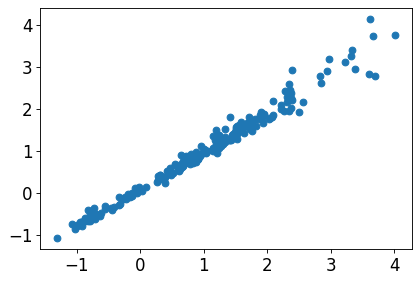

In [377]:
plt.scatter(xx["Score_w"].values, xx["Score_b"].values)

### Mat Multi

In [26]:
beta = np.array([SparkMetaBias.loc[X, "EFFECT"] for X in ConnMat.index.values])
beta[beta<0] = 0
#beta =

In [50]:
W = np.matrix(ConnMat_binary_norm.values)
I = np.eye(ConnMat.shape[0])
D = np.eye(ConnMat.shape[0]) 
beta = I * beta

In [52]:
F = beta @ np.linalg.inv(I - (1-beta) @ W)

In [53]:
F.shape

(213, 213)

In [54]:
E = F @ D

In [55]:
E

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00072838,  0.29253954, -0.00290628, ..., -0.00114143,
         -0.0033202 , -0.00082505],
        [-0.00064269, -0.00142616,  0.23785887, ..., -0.00095245,
         -0.00144011, -0.00069668],
        ...,
        [-0.00054708, -0.00121334, -0.00114275, ...,  0.1914412 ,
         -0.00124829, -0.000593  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [56]:
Seq = []
for i in range(100):
    E = F * E
    Seq.append(np.diagonal(E))

In [60]:
Seq = np.array(Seq)
Seq.shape

(100, 213)

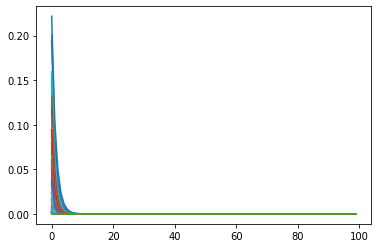

In [63]:
for i in range(Seq.shape[1]):
    plt.plot(Seq[:, i])